# LDA from scratch 

Date: 3/22/19

---

### Inspiration for the Deeper Dive

Special thanks to Sebastian Raschka for putting together the code for this exercise in a concise and easy to follow manner: https://sebastianraschka.com/Articles/2014_python_lda.html

#### Data
Iris dataset from sklearn

#### Goal
Used the code to walk through the process

Key Takeaways:

- LDA is similar to PCA in that it attempts to find the PC's that maximize the variance in the dataset but w/ 2 distinct differences: 

    1. Supervised
    2. Find eigenvalues (direction) that maximize the separation between the distinct classes.

*Eigenvectors direction, Eigenvalues magnitude/length*

### Key Assumptions

- Normality of features being independent and identical covariance matrices for every class.

#### Key Formulas:

2 ways to get the covariance matrix:

1. Scatter Matrix (w/in class scatter matrix) $S_{W}$

$$S_{W}=\sum_{i=1}^c S_{i}$$

where

$$S=\sum+{x\in D_{i}}^n(x_{k}-m)(x_{k}-m)^T$$

and $m$ is the mean vector

$$m=\frac{1}{n}\sum_{k=1}^nx_{k}$$

2. Covariance Matrix

Same as the scatter matrix except a scaling factor of $\frac{1}{N-1}$ is employed

---

In [1]:
import numpy as np
import pandas as pd

np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets

#### Iris DataSet: Import, Format & Organize

In [2]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

X_y_arr = np.concatenate((X, y.reshape(150,1)), axis=1)

df = pd.DataFrame(X_y_arr)

In [3]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [4]:
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0
149,5.9,3.0,5.1,1.8,2.0


#### Plotting the Unreduced Feature Space

In [5]:
label_dict = {0: 'Setosa', 1: 'Versicolor', 2:'Virginica'}

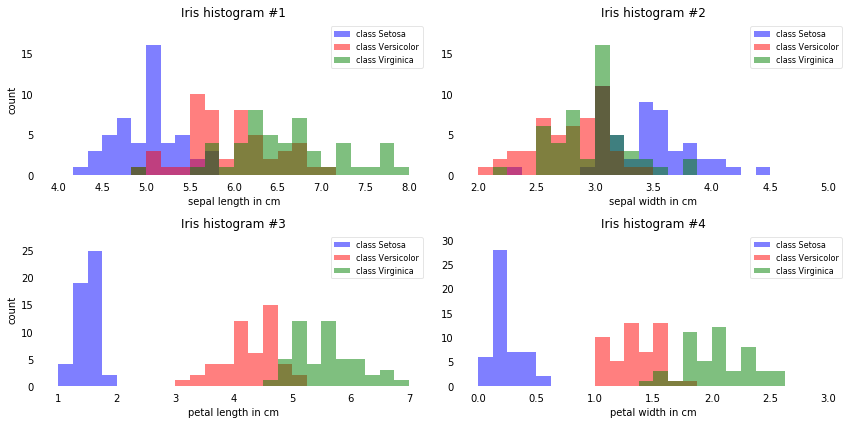

In [6]:
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab, col in zip(range(0,3), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

---
### 1. Compute the Class Means

In [7]:
mean_vectors = []

for cl in range(0,3):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' % (cl, mean_vectors[cl]))

Mean Vector class 0: [5.006 3.418 1.464 0.244]

Mean Vector class 1: [5.936 2.77  4.26  1.326]

Mean Vector class 2: [6.588 2.974 5.552 2.026]



---

### 2.1 Within Class Scatter Matrix $S_{W}$

$$S_{W}=\sum_{i=1}^c S_{i}$$

where scatter for each class:

$S_{i}=\sum_{x\in D_{i}}^n (x-m_{i})(x-m_{i})^T$

and $m_{i}$ is the mean vector

$m_{i}=\frac{1}{n_{i}}\sum_{x\in D_{i}}^n x_{k}$

In [8]:
S_W = np.zeros((4,4))

for cl, mv in zip(range(0,3), mean_vectors):
    class_sc_mat = np.zeros((4,4))
    for row in X[y==cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1)
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat
    
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### Covariance Matrix (Scaled Alternate to Scatter Matrix)

Covariance Matrix (scaled by sample size $N_{i}-1$)

$$S_{W}=\sum_{i=1}^c (N_{i}-1)\Sigma_{i}$$

where $\Sigma_{i}=\frac{1}{N_{i}-1}\sum_{x\in D_{i}}^n(x-m_{i})(x-m_{i})^T$

### 2.2 Between-class Scatter Matrix $S_{B}$

the second scatter matrix that needs to be calcualted is between-class scatter matrix:

$$S_{B}=\sum_{i=1}^c N_{i}(m_{i}-m)(m_{i}-m)^T$$

where 
$m$ is the overall mean, and $m_{i}$ and $N_{i}$ are the sample mean and sizes of the respective classes

In [11]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))

for i, mean_vec in enumerate(mean_vectors):
    n = X[y==i,:].shape[0]
#     print(n)
    mean_vec = mean_vec.reshape(4,1)
    overall_mean = overall_mean.reshape(4,1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    
print('between-class Scatter Matrix:\n\n', S_B)

between-class Scatter Matrix:

 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


---
### 3. Eigen Decomposition

Time to solve the matrix 

$$A = S_{W}^{-1}S_{B}$$

from here we get:

$$Av=\lambda v$$

where

$v=$ eigenvector

$\lambda=$ eigenvalue

Now we need to find the eigenvalues and their corresponding eigenvectors that reduce the feature space into a subspace that captures the most variance

In [16]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.0666]
 [ 0.3143]
 [ 0.3854]
 [-0.865 ]]
Eigenvalue 3: -2.28e-15

Eigenvector 4: 
[[-0.3446]
 [ 0.4249]
 [ 0.4788]
 [-0.6866]]
Eigenvalue 4: 6.34e-16


In [17]:
# Check to ensure that Av =lamv
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

ok


---

### 4. Reducing Dimensions by Selecting Eigenvectors according to Eigenvalues in Descending Order

We want to find the direction or eigenvectors that contain the maximum magnitude/length which means that we rank the eigenvalues in descending order.

In [18]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

eig_pairs

[(32.27195779972982, array([ 0.2049,  0.3871, -0.5465, -0.7138])),
 (0.2775668638400461, array([-0.009 , -0.589 ,  0.2543, -0.767 ])),
 (2.2833103419793817e-15, array([ 0.0666,  0.3143,  0.3854, -0.865 ])),
 (6.342134974218695e-16, array([-0.3446,  0.4249,  0.4788, -0.6866]))]

here we see that the first 2 eigenvalues account for ~99% of the "explained variance" which we will show below

In [19]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i, j in enumerate(eig_pairs):
    print('Eigenvalue {0:}: {1:.2%}'.format(i, (j[0]/eigv_sum).real))

Variance explained:

Eigenvalue 0: 99.15%
Eigenvalue 1: 0.85%
Eigenvalue 2: 0.00%
Eigenvalue 3: 0.00%


Now we have our 2 eigenvector directions that will form the new subspace

In [20]:
W = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))
print(W.real)

[[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]


---

### 5. New Reduced Subspace $Y=X*W$

Now we will plot the new 2-dimensional subspace that shows how effective our linear discriminants were in separating the classes

In [23]:
X_lda = X.dot(W)
assert X_lda.shape == (150, 2)

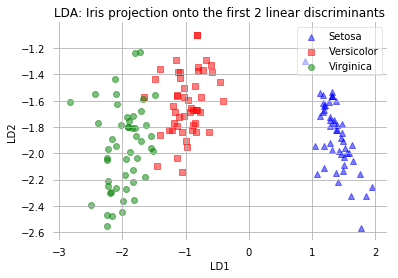

In [24]:
def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(0,3),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()